# **Weekly Project - Week 4**

This week you'll be provided with a set of stereo images, and your task is to undistort and rectify the images, such that they can be used with the stereo depth reconstruction you made on day 6. You are still not allowed to use opencv functions for block matching/template matching, however you are free to use opencv when undistorting the images.

We will start with the zip called rs with undisorting the pictures:

In [7]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

# Dimensions of the chessboard pattern
nb_vertical = 9  # Inner corners along the width (columns)
nb_horizontal = 6  # Inner corners along the height (rows)

# Size of each square in the chessboard pattern (in millimeters)
square_size = 33.6

# Prepare object points, e.g. (0,0,0), (33.6,0,0), (67.2,0,0), ..., (201.6,168,0)
objp = np.zeros((nb_horizontal * nb_vertical, 3), np.float32)
objp[:, :2] = np.mgrid[0:nb_vertical, 0:nb_horizontal].T.reshape(-1, 2)
objp *= square_size  # Multiply by the actual square size (33.6 mm)

# Arrays to store object points and image points from all the images.
objpoints = []  # 3D points in real world space
imgpoints = []  # 2D points in image plane.

# Load all calibration images
images = glob.glob('rs/*.png')
assert images, "No images found. Please check the image path."

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nb_vertical, nb_horizontal), None)

    # If found, add object points and image points
    if ret:
        objpoints.append(objp)

        # Refine corner locations for better accuracy
        corners = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1),
                                   criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001))
        imgpoints.append(corners)

        # Draw and display the corners on the chessboard
        img = cv2.drawChessboardCorners(img, (nb_vertical, nb_horizontal), corners, ret)
        cv2.imshow('img', img)
        cv2.waitKey(500)

cv2.destroyAllWindows()


Using the extracted corners we can obtain a camera matrix that contains the information needed to undistort images and the last step is to actually undistort an image:

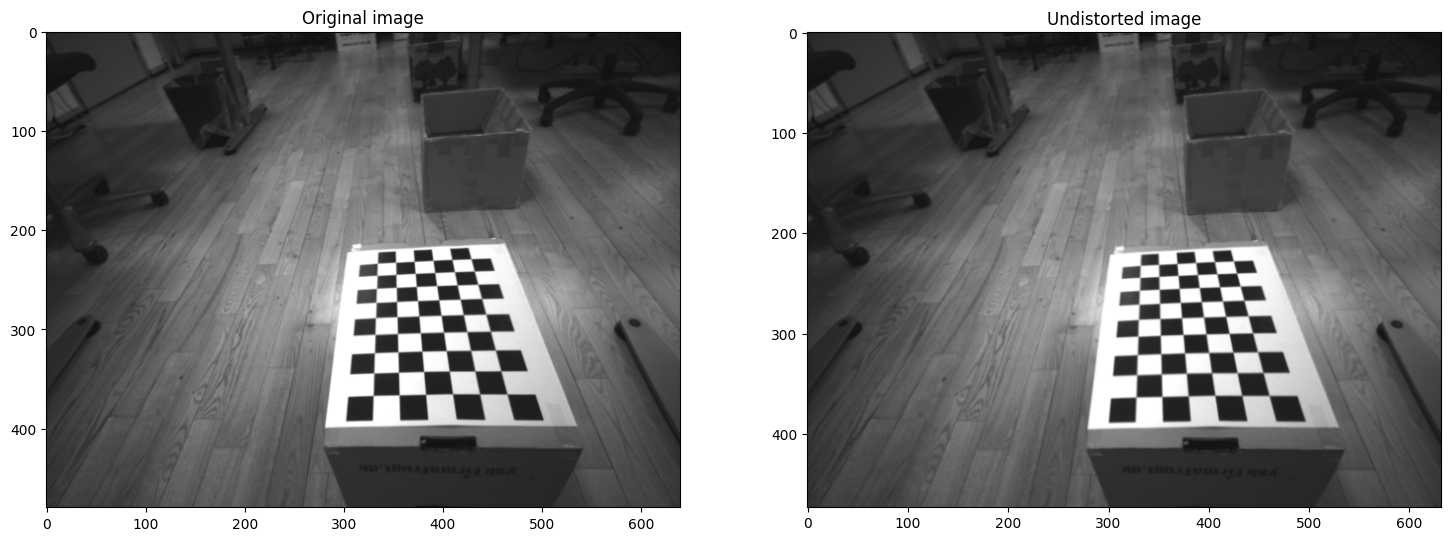

In [8]:
# Perform camera calibration
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# Load an example image (left image from the stereo pair)
img = cv2.imread('rs/left-0053.png')
h, w = img.shape[:2]

# Get the optimal camera matrix for undistortion
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w, h), 1, (w, h))

# Undistort the image
dst = cv2.undistort(img, mtx, dist, None, newcameramtx)

# Crop the image based on ROI
x, y, w, h = roi
dst = dst[y:y+h, x:x+w]

# Plot the original and undistorted images
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 18))
ax[0].imshow(img[..., [2, 1, 0]])
ax[0].set_title('Original image')
ax[1].imshow(dst[..., [2, 1, 0]])
ax[1].set_title('Undistorted image')
plt.show()

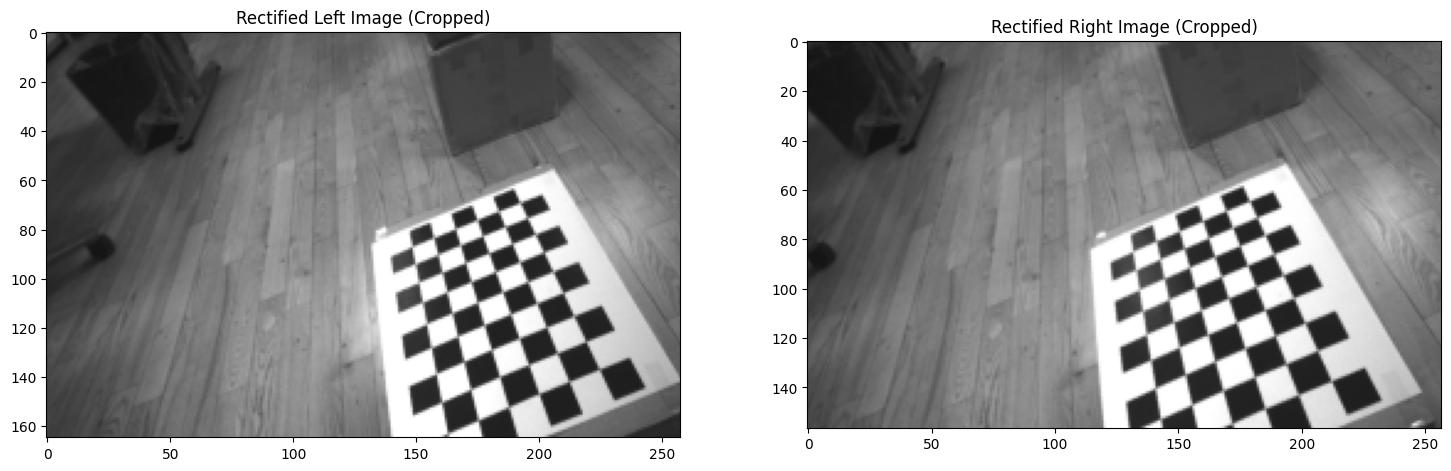

In [20]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

# Dimensions of the chessboard pattern
nb_vertical = 9  # Inner corners along the width (columns)
nb_horizontal = 6  # Inner corners along the height (rows)

# Size of each square in the chessboard pattern (in millimeters)
square_size = 33.6

# Prepare object points, e.g. (0,0,0), (33.6,0,0), (67.2,0,0), ..., (201.6,168,0)
objp = np.zeros((nb_horizontal * nb_vertical, 3), np.float32)
objp[:, :2] = np.mgrid[0:nb_vertical, 0:nb_horizontal].T.reshape(-1, 2)
objp *= square_size  # Multiply by the actual square size (33.6 mm)

# Arrays to store object points and image points from all the images.
objpoints = []  # 3D points in real world space
imgpoints_left = []  # 2D points in image plane (left camera)
imgpoints_right = []  # 2D points in image plane (right camera)

# Load all calibration images for the left and right cameras
left_images = sorted(glob.glob('rs/left-*.png'))
right_images = sorted(glob.glob('rs/right-*.png'))

assert len(left_images) > 0, "No left images found. Please check the file paths."
assert len(right_images) > 0, "No right images found. Please check the file paths."
assert len(left_images) == len(right_images), "Mismatched number of left and right images."

# Get image shape from the first image (assuming all images have the same dimensions)
example_img = cv2.imread(left_images[0])
assert example_img is not None, "Error loading the first left image."
image_shape = example_img.shape[1::-1]  # Get (width, height) from the first image

# Process each stereo image pair to find chessboard corners
for left_img_path, right_img_path in zip(left_images, right_images):
    # Load left and right images
    left_img = cv2.imread(left_img_path)
    right_img = cv2.imread(right_img_path)
    
    # Convert to grayscale
    gray_left = cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY)
    gray_right = cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners in both images
    ret_left, corners_left = cv2.findChessboardCorners(gray_left, (nb_vertical, nb_horizontal), None)
    ret_right, corners_right = cv2.findChessboardCorners(gray_right, (nb_vertical, nb_horizontal), None)

    if ret_left and ret_right:
        # Refine corner locations for better accuracy
        corners_left = cv2.cornerSubPix(gray_left, corners_left, (11, 11), (-1, -1),
                                        criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001))
        corners_right = cv2.cornerSubPix(gray_right, corners_right, (11, 11), (-1, -1),
                                         criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001))
        
        # Append the points
        objpoints.append(objp)
        imgpoints_left.append(corners_left)
        imgpoints_right.append(corners_right)

# Perform stereo calibration
ret, camera_matrix_left, dist_coeffs_left, camera_matrix_right, dist_coeffs_right, \
R, T, E, F = cv2.stereoCalibrate(objpoints, imgpoints_left, imgpoints_right, None, None, None, None,
                                 image_shape, flags=cv2.CALIB_FIX_INTRINSIC)

# Stereo rectification
rectify_scale = 1  # 0 to crop the image, 1 to keep full image
R1, R2, P1, P2, Q, roi_left, roi_right = cv2.stereoRectify(camera_matrix_left, dist_coeffs_left,
                                                           camera_matrix_right, dist_coeffs_right,
                                                           image_shape, R, T, alpha=rectify_scale)

# Compute rectification maps for both cameras
left_map_x, left_map_y = cv2.initUndistortRectifyMap(camera_matrix_left, dist_coeffs_left, R1, P1, image_shape, cv2.CV_32FC1)
right_map_x, right_map_y = cv2.initUndistortRectifyMap(camera_matrix_right, dist_coeffs_right, R2, P2, image_shape, cv2.CV_32FC1)

# Load an example pair of images
img_left = cv2.imread('rs/left-0053.png')
img_right = cv2.imread('rs/right-0053.png')

# Apply rectification using remap
rectified_left = cv2.remap(img_left, left_map_x, left_map_y, cv2.INTER_LINEAR)
rectified_right = cv2.remap(img_right, right_map_x, right_map_y, cv2.INTER_LINEAR)

# Crop the rectified images using the ROI
x_left, y_left, w_left, h_left = roi_left
rectified_left = rectified_left[y_left:y_left+h_left, x_left:x_left+w_left]

x_right, y_right, w_right, h_right = roi_right
rectified_right = rectified_right[y_right:y_right+h_right, x_right:x_right+w_right]

# Display cropped rectified images
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 18))
ax[0].imshow(rectified_left[..., [2, 1, 0]])
ax[0].set_title('Rectified Left Image (Cropped)')
ax[1].imshow(rectified_right[..., [2, 1, 0]])
ax[1].set_title('Rectified Right Image (Cropped)')
plt.show()


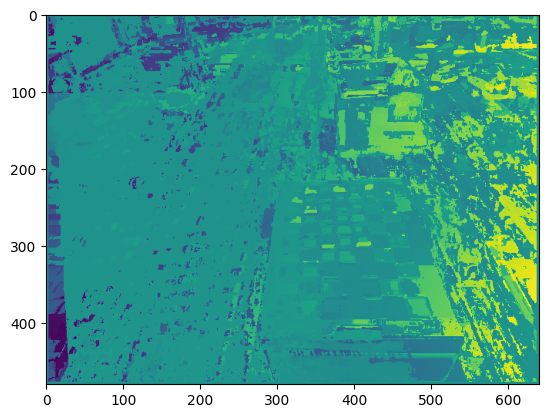

In [22]:
def sad(img1, img2):
    
    return np.sum(np.abs(img1 - img2))

def find_nose_location(img, span, height):
    
    width = img.shape[1]
    span_height, span_width = span.shape
    
    # Compute the starting row and extract the row block from the span image
    row_start = (span_height - height) // 2
    span_row_block = span[row_start:row_start + height, :]
    
    min_sad = float('inf')
    nose_col = -1
    
    # Iterate over possible columns in the span image where the template can fit
    for col in range(span_width - width + 1):
        # Extract the current block from the span row
        span_block = span_row_block[:, col:col + width]
       
        # Compute SAD between the template and the current block
        sad_value = sad(img, span_block)
        
        # Update minimum SAD and column index if necessary
        if sad_value < min_sad:
            min_sad = sad_value
            nose_col = col
    
    
    return (nose_col+3)

# f, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(18,18))
# ax_left.imshow(img_left2)
# ax_right.imshow(img_right2)

def compute_disparity_map(tsukuba_left, tsukuba_right, window_size=7):
    # Get the shape of the left and right images
    height, width = tsukuba_left.shape
    disparity_map = np.zeros((height, width), dtype=np.int32)

    half_window = window_size // 2

    # Iterate over each row of the images
    for row in range(half_window, height - half_window):
        for col in range(half_window, width - half_window):
            # Extract the 7x7 template from the left image
            template = tsukuba_left[row - half_window: row + half_window + 1, col - half_window: col + half_window + 1]
            
            # Use find_nose_location to find the best matching column in the right image for this row
            best_match_col = find_nose_location(template, tsukuba_right[row - half_window: row + half_window + 1, :], window_size)
            
            # Compute the disparity as the difference between column positions in the left and right images
            disparity = col - best_match_col
            disparity_map[row, col] = disparity
    
    return disparity_map

gray_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
gray_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)

# Compute disparity map
disparity_map = compute_disparity_map(gray_left, gray_right)

# Visualize disparity map



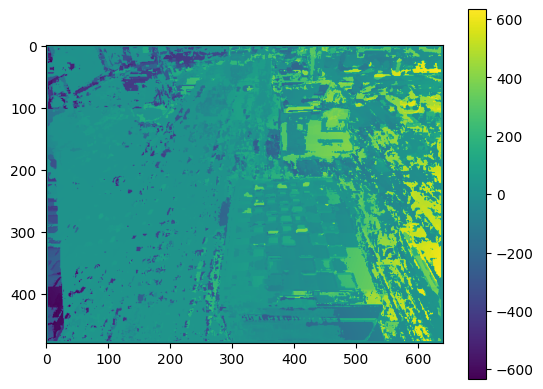

In [23]:
plt.imshow(disparity_map)
plt.colorbar()